Si vous utilisez Google Colab, exécutez d'abord la cellule ci-dessous. La cellule présume que le code du TP1 (le dossier prog) se trouve dans MyDrive/IFT780/TP1/. Si ce n'est pas le cas, changez le chemin pour le vôtre. 

In [ ]:
# à exécuter uniquement sur les serveurs de google colab
from google.colab import drive
drive.mount('/content/drive')
!cp -r drive/MyDrive/IFT780/TP1/prog/* .

# TP1: Réseau de neurones à trois couches, fonction de perte *Erreur quadratique* (Mean squared error)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# pour automatiquement recharger les modules externes
# voir http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<font size=5>Code simple pour un MLP à trois couches</font>

Le but de ce notebook est de vous familiariser avec le code effectuant une **propagation avant**, une **propagation arrière** puis une **descente de gradient**.  Vous verrez du code "naif" ainsi qu'une implémentation plus "réelle" utilisant d'une *cache*.

Bien qu'aucune note ne soit attribée à ce notebook, prenez le temps de **bien comprendre les notions qui suivent**.

Il est d'ailleurs recommandé de "jouer" avec le code afin de :

* implanter d'autres fonctions d'activation (relu, tanh, etc)
* implanter un réseau à 2 couche puis à 4 couches 
* tester une autre loss (entropie croisée)
* etc.

Le but de ce notebook est de vous préparer au *tp1_neural_net.ipynb* dans lequel les concepts abordés ici seront encapsulés dans des **classes**

In [2]:
##############################################################################
# Les variables déterminant la forme du réseau                               #
##############################################################################

num_input_neurons = 4
num_hidden_neurons_1 = 5
num_hidden_neurons_2 = 6
num_output_neurons = 3

In [3]:
##############################################################################
# Création de données jouets aléatoires                                      #
##############################################################################

def create_random_toy_data(nb_data, nb_input_neurons, num_output_neurons):
    np.random.seed(1)
    
    X = 10 * np.random.randn(nb_data, nb_input_neurons)
    y = 0.1 * np.random.randn(nb_data, num_output_neurons)
        
    return X, y

# Pour simplifier les choses, commençons avec une seule donnée
X, y = create_random_toy_data(1, num_input_neurons, num_output_neurons)
print(X.shape)
print(y)

(1, 4)
[[ 0.08654076 -0.23015387  0.17448118]]


In [4]:
##############################################################################
# Création + initialisation des matrices de poids                            #
##############################################################################
def create_random_weights(in_size, num_1, num_2, nb_out):
    Weight_1 = np.random.normal(loc=0.0, scale=0.01, size=(in_size, num_1))
    Weight_2 = np.random.normal(loc=0.0, scale=0.01, size=(num_1, num_2))
    Weight_3 = np.random.normal(loc=0.0, scale=0.01, size=(num_2, nb_out))
    W = {"W1": Weight_1, "W2": Weight_2, "W3": Weight_3}
    return W

W = create_random_weights(num_input_neurons, num_hidden_neurons_1, num_hidden_neurons_2, num_output_neurons)

print("Poids de la premiere couche = \n", W['W1'])
print("Poids de la 2e couche = \n", W['W2'])
print("Poids de la 3e couche = \n", W['W3'])

Poids de la premiere couche = 
 [[-0.00761207  0.00319039 -0.0024937   0.01462108 -0.02060141]
 [-0.00322417 -0.00384054  0.01133769 -0.01099891 -0.00172428]
 [-0.00877858  0.00042214  0.00582815 -0.01100619  0.01144724]
 [ 0.00901591  0.00502494  0.00900856 -0.00683728 -0.0012289 ]]
Poids de la 2e couche = 
 [[-0.00935769 -0.00267888  0.00530355 -0.00691661 -0.00396754 -0.00687173]
 [-0.00845206 -0.00671246 -0.00012665 -0.0111731   0.00234416  0.01659802]
 [ 0.00742044 -0.00191836 -0.00887629 -0.00747158  0.01692455  0.00050808]
 [-0.00636996  0.00190915  0.02100255  0.00120159  0.00617203  0.0030017 ]
 [-0.0035225  -0.01142518 -0.00349343 -0.00208894  0.00586623  0.00838983]]
Poids de la 3e couche = 
 [[ 0.00931102  0.00285587  0.00885141]
 [-0.00754398  0.01252868  0.0051293 ]
 [-0.00298093  0.00488518 -0.00075572]
 [ 0.01131629  0.01519817  0.02185575]
 [-0.01396496 -0.01444114 -0.00504466]
 [ 0.00160037  0.00876169  0.00315635]]


In [5]:
##############################################################################
# Fonction d'activation + sa dérivée                                         #
##############################################################################
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def derivative_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

# résultat de la sigmoide et de sa dérivée pour 3 valeurs différentes soient: 0, 1 et -1

print('sig(0) = ', sigmoid(0), '  sig(1) = ', sigmoid(1), '  sig(-1) = ', sigmoid(-1))
print('dsig(0) = ', derivative_sigmoid(0), '  dsig(1) = ', derivative_sigmoid(1), '  dsig(-1) = ', derivative_sigmoid(-1))


sig(0) =  0.5   sig(1) =  0.7310585786300049   sig(-1) =  0.2689414213699951
dsig(0) =  0.25   dsig(1) =  0.19661193324148185   dsig(-1) =  0.19661193324148185


# Code naif

In [6]:
##############################################################################
# Une simple propagation avant                                               #
##############################################################################

def forward_pass(W, X, activation):
    H1 = X.dot(W['W1'])
    L1 = activation(H1)
    
    H2 = L1.dot(W['W2'])
    L2 = activation(H2)
    
    H3 = L2.dot(W['W3'])
    score = H3
    
    return score

score = forward_pass(W, X, sigmoid)

print('score = ', score)

score =  [[-0.00122181  0.01480057  0.01648451]]


In [7]:
##############################################################################
# Une simple propagation + loss quadratique                                  #
##############################################################################
def forward_pass_with_loss_MSE(W, X, y, activation):
    H1 = X.dot(W['W1'])
    L1 = activation(H1)
    
    H2 = L1.dot(W['W2'])
    L2 = activation(H2)
    
    H3 = L2.dot(W['W3'])
    score = H3
    
    loss = np.sum(np.power(score - y, 2))
    
    return score, loss

score, loss = forward_pass_with_loss_MSE(W, X, y, sigmoid)

print('score = ', score)
print('loss MSE = ', loss)

score =  [[-0.00122181  0.01480057  0.01648451]]
loss MSE =  0.09266789279428708


In [8]:
##############################################################################
# Fonction effectuant une propagation AVANT + ARRIERE                        #
#                                                                            #
# WARNING-WARNING-WARNING!                                                   #
# Portez attention à la dimension de chaque opération, c'est ce qui est le   #
# plus mélangeant! Pour comprendre ce code, il est préférable d'effectuer    #
# en premier la dérivation manuellement sur papier.                          #
#                                                                            #
# NOTE : une bonne pratique consiste à recoder cette fonction mais avec une  #
#       autre loss et/ou pour un nombre arbitraire de classes.               #
##############################################################################

def forward_naive_backward_pass_with_loss_MSE(W, X, y, activation, derivative_activation):
    # X : 1x4
    # W1 : 4x5
    # W2 : 5x6
    # W3 : 6x3
    H1 = X.dot(W['W1']) #  H1 : 1x4.4x5 => 1x5
    L1 = activation(H1) #  L1 : 1x5
    
    H2 = L1.dot(W['W2']) # H2 : 1x5.5x6 => 1x6
    L2 = activation(H2)  # L2 : 1x6
    
    H3 = L2.dot(W['W3']) # H3 : 1x6.6x3 => 1x3
    score = H3           # score : 1x3
    
    loss = np.sum(np.power(score - y, 2)) # loss : 1x3
    
    dLoss_dScore = 2 * (score - y)        # dLoss_dScore : 1x3
    
    dH3_dW3 = L2                          # dH3_dW3 : 1x6
    dH3_dL2 = W['W3']                     # dH3_dL2 : 6x3
    dL2_dH2 = derivative_activation(H2)   # dL2_dH2 : 1x6
    dH2_dW2 = L1                          # dH2_dW2 : 1x5
    dH2_dL1 = W['W2']                     # dH3_dL2 : 5x6
    dL1_dH1 = derivative_activation(H1)   # dL1_dH1 : 1x5
    dH1_dW1 = X                           # dH1_dW1 : 1x4
    
    # dLoss_dScore * dH3_dW3 
    #      1x3         1x6   => 6x3
    dW3 = dLoss_dScore.T.dot(dH3_dW3).T
    
    # dLoss_dScore * dH3_dL2 * dL2_dH2 * dH2_dW2 
    #      1x3         6x3      ----       1x5   => 5x6
    dW2 = dLoss_dScore.dot(dH3_dL2.T)    # 1x3.3x6 : 1x6
    dW2 = dW2 * dL2_dH2                  # 1x6
    dW2 = dW2.T.dot(dH2_dW2).T           # 6x1 . 1x5.
    
    # dLoss_dScore * dH3_dL2 * dL2_dH2 * dH2_dL1 * dL1_dH1 * dH1_dW1  
    #      1x3         6x3      ----       5x6      ----       1x4  => 4x5
    dW1 = dLoss_dScore.dot(dH3_dL2.T)    # 1x3.3x6 : 1x6
    dW1 = dW1 * dL2_dH2                  # 1x6
    dW1 = dW1.dot(dH2_dL1.T)             # 1x6.6x5 : 1x5
    dW1 = dW1 * dL1_dH1                  # 1x5.
    dW1 = dW1.T.dot(dH1_dW1).T         # 5x1.1x4.t : 4x5 
    
    dW = {'dW1':dW1, 'dW2':dW2, 'dW3':dW3}
    return score, loss, dW

score, loss, dW = forward_naive_backward_pass_with_loss_MSE(W, X, y, sigmoid, derivative_sigmoid)

# Meme dimensions?  Il faut s'assurer que la dimension des matrices W est la même que celle des gradients dW
print(dW['dW1'].shape,  ' vs ', W['W1'].shape)
print(dW['dW2'].shape,  ' vs ', W['W2'].shape)
print(dW['dW3'].shape,  ' vs ', W['W3'].shape)

(4, 5)  vs  (4, 5)
(5, 6)  vs  (5, 6)
(6, 3)  vs  (6, 3)


iter =  0
iter =  10
iter =  20
iter =  30
iter =  40
iter =  50
iter =  60
iter =  70
iter =  80
iter =  90


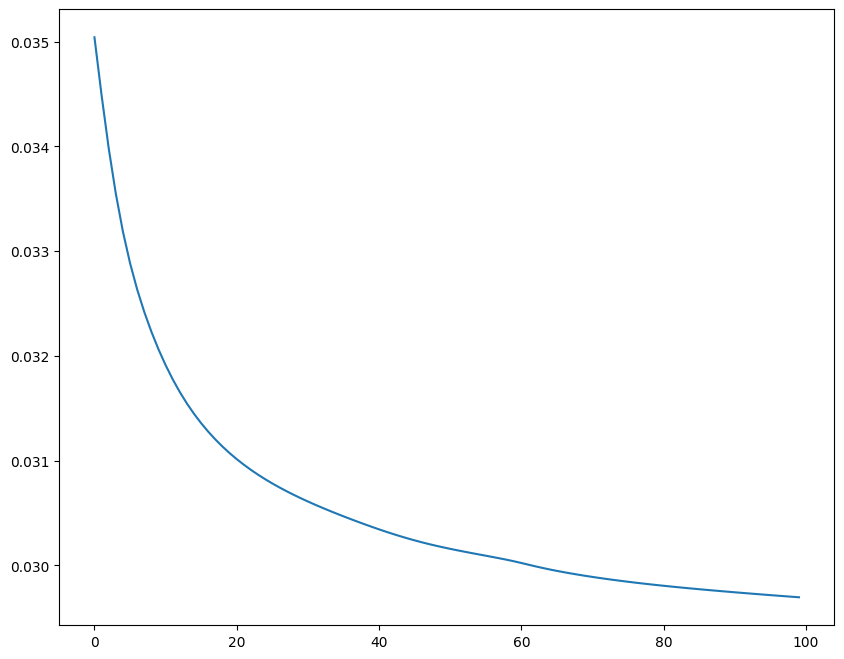

In [9]:
##############################################################################
# Descente de gradient sur des données aléatoires                            #
# Le but est de montrer que le réseau "apprend" quelque chose au bout de     #
# quelques epochs                                                            #
##############################################################################
train_size = 1000
lr = 0.1
history_loss = []
X, y = create_random_toy_data(train_size, num_input_neurons, num_output_neurons)

W = create_random_weights(num_input_neurons, num_hidden_neurons_1, num_hidden_neurons_2, num_output_neurons)
for iter in range(100):
    if np.mod(iter,10)==0:
        print("iter = ", iter)
    
    loss_epoch = 0
    for i in range(train_size):
        
        x_data = np.expand_dims(X[i,:], axis=0)
        score, loss, dW = forward_naive_backward_pass_with_loss_MSE(W, x_data, y[i,:], sigmoid, derivative_sigmoid)
        W['W1'] = W['W1'] - lr*dW['dW1']
        W['W2'] = W['W2'] - lr*dW['dW2']
        W['W3'] = W['W3'] - lr*dW['dW3']
        
        loss_epoch += loss
        
    history_loss.append(loss_epoch/train_size)

# En principe, la loss devrait décroitre
plt.plot(history_loss)
plt.show() 

# Code plus réaliste utilisant une "cache"

L'idée derrière la *cache* est de stocker en mémoire les variables calculées lors de la propagation avant qui seront utiles lors de la rétro-propagation.

Au fond, la *cache* permet de **diviser en 2 fonctions** la précédente fonction **forward_naive_backward_pass_with_loss_MSE**.

In [10]:
def real_forward_pass_with_loss_MSE(W, X, y, activation, derivative_activation):
    # X : 1x4
    # W1 : 4x5
    # W2 : 5x6
    # W3 : 6x3
    H1 = X.dot(W['W1']) #  H1 : 1x4.4x5 => 1x5
    L1 = activation(H1) #  L1 : 1x5
    
    H2 = L1.dot(W['W2']) # H2 : 1x5.5x6 => 1x6
    L2 = activation(H2)  # L2 : 1x6
    
    H3 = L2.dot(W['W3']) # H3 : 1x6.6x3 => 1x3
    score = H3           # score : 1x3
    
    loss = np.sum(np.power(score - y, 2)) # loss : 1x3
    
    cache = {'H1':H1, 'L1':L1, 'H2':H2, 'L2':L2, 'score':score}
    return loss, cache

def real_backprop_pass_with_loss_MSE(W, X, y, activation, derivative_activation, cache):
    dLoss_dScore = 2 * (cache['score'] - y)
    dW3 = dLoss_dScore.T.dot(cache['L2']).T
    
    dW2 = dLoss_dScore.dot(W['W3'].T)              
    dW2 = dW2 * derivative_activation(cache['H2'])
    dW2 = dW2.T.dot(cache['L1']).T
    
    dW1 = dLoss_dScore.dot(W['W3'].T)
    dW1 = dW1 * derivative_activation(cache['H2'])
    dW1 = dW1.dot(W['W2'].T)
    dW1 = dW1 * derivative_activation(cache['H1'])
    dW1 = dW1.T.dot(X).T
    
    dW = {'dW1':dW1, 'dW2':dW2, 'dW3':dW3}
    return dW

In [11]:
##############################################################################
# Descente de gradient sur des données aléatoires                            #
# Le but est de montrer que le réseau "apprend" quelque chose au bout de     #
# quelques epochs                                                            #
##############################################################################
X, y = create_random_toy_data(1, num_input_neurons, num_output_neurons)

loss, cache = real_forward_pass_with_loss_MSE(W, X, y, sigmoid, derivative_sigmoid)
dW = real_backprop_pass_with_loss_MSE(W, X, y, sigmoid, derivative_sigmoid, cache)

# Meme dimensions? oui!
print(dW['dW1'].shape,  ' vs ', W['W1'].shape)
print(dW['dW2'].shape,  ' vs ', W['W2'].shape)
print(dW['dW3'].shape,  ' vs ', W['W3'].shape)

(4, 5)  vs  (4, 5)
(5, 6)  vs  (5, 6)
(6, 3)  vs  (6, 3)


iter =  0
iter =  10
iter =  20
iter =  30
iter =  40
iter =  50
iter =  60
iter =  70
iter =  80
iter =  90


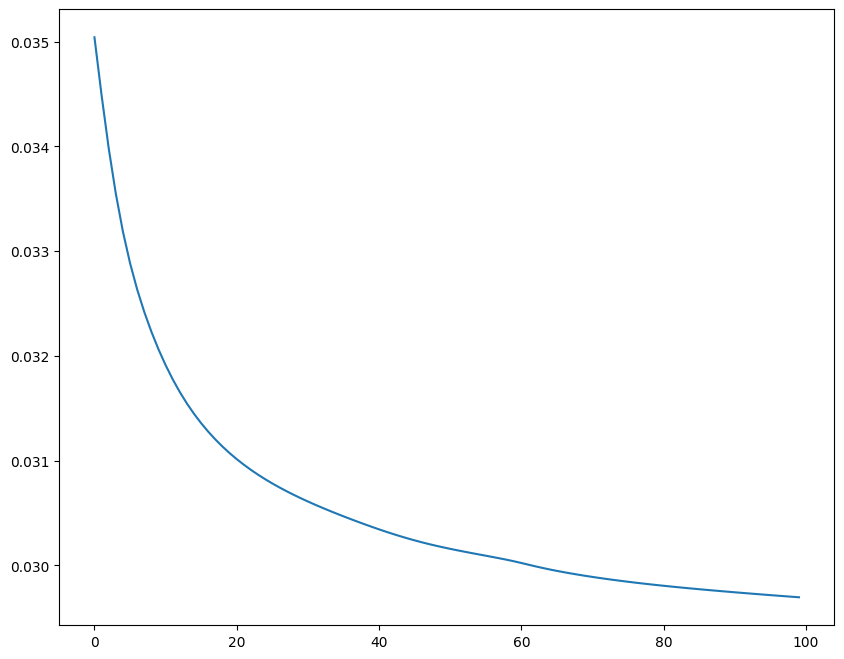

In [12]:
train_size = 1000
lr = 0.1
history_loss = []
X, y = create_random_toy_data(train_size, num_input_neurons, num_output_neurons)
W = create_random_weights(num_input_neurons, num_hidden_neurons_1, num_hidden_neurons_2, num_output_neurons)

# 100 epochs
for iter in range(100):
    if np.mod(iter,10)==0:
        print("iter = ", iter)
    
    loss_epoch = 0
    for i in range(train_size):
        
        x_data = np.expand_dims(X[i,:], axis=0)
        loss, cache = real_forward_pass_with_loss_MSE(W, x_data, y[i,:], sigmoid, derivative_sigmoid)
        dW = real_backprop_pass_with_loss_MSE(W, x_data, y[i,:], sigmoid, derivative_sigmoid, cache)

        W['W1'] = W['W1'] - lr*dW['dW1']
        W['W2'] = W['W2'] - lr*dW['dW2']
        W['W3'] = W['W3'] - lr*dW['dW3']
        
        loss_epoch += loss
        
    history_loss.append(loss_epoch/train_size)

plt.plot(history_loss)
plt.show() 
